<a href="https://colab.research.google.com/github/KelvinLam05/k-means_clustering_for_customer_segmentation/blob/main/k_means_clustering_for_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal of the project** 

Based on the given satisfaction and loyalty level of customer, we have to find in which segment they will fall.

**K-means clustering**

K-means is one of the most widely used algorithms for clustering data and falls into the unsupervised learning group of machine learning models. It’s ideal for many forms of customer segmentation.

**Assumptions in k-means clustering**

The k means algorithm makes several assumptions about the data that are important to understand. While it often still “works” if we ignore them, we will see far better results if you transform the data to work within its assumptions.

* Equal variance: K-means assumes that variables have the same variance. The mean and standard deviation of the values should be similar. If they’re not, you’ll need to scale and standardise the variables.

* Normal distribution: K-means expects the distribution of each variable to be normal, not highly skewed. If it’s skewed, you’ll need to transform it first using a log transform, Box Cox, or similar.

* Similarly sized spherical clusters: It also expects data to form spherical clusters of roughly similar size. If your data aren’t distributed in this way, you may need a different algorithm.

**Load the packages**

In [255]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

**Load the data**

In [256]:
# Load dataset
df = pd.read_csv('/content/market_segmentation.csv')

In [257]:
# Change the data frame's column names to lower case
df.columns = df.columns.str.lower()

In [258]:
# Examine the data
df.head()

,satisfaction,loyalty
0,4,-1.33
1,6,-0.28
2,5,-0.99
3,7,-0.29
4,4,1.06


In [259]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   satisfaction  30 non-null     int64  
 1   loyalty       30 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 608.0 bytes


**Check for missing values**

df.isnull( ).sum( ) shows us that we don’t have any null values.

In [260]:
df.isnull().sum()

satisfaction    0
loyalty         0
dtype: int64

**Examine the data**

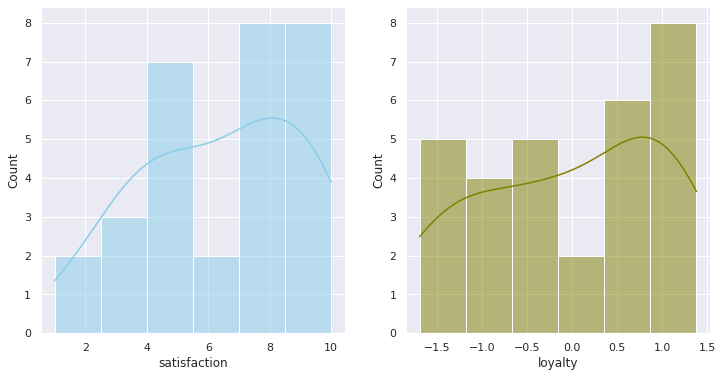

In [261]:
# Set a grey background
sns.set(style = 'darkgrid')

fig, axs = plt.subplots(1, 2, figsize = (12, 6))

sns.histplot(data = df, x = 'satisfaction', kde = True, color = 'skyblue', ax = axs[0])
sns.histplot(data = df, x = 'loyalty', kde = True, color = 'olive', ax = axs[1])

plt.show()

**Skewness**

In statistics, skewness is a measure of the asymmetry of the probability distribution of a random variable about its mean. In other words, skewness tells us the amount and direction of skew (departure from horizontal symmetry). The skewness value can be positive or negative, or even undefined. If skewness is 0, the data are perfectly symmetrical, although it is quite unlikely for real-world data. As a general rule of thumb:

* If skewness is less than -1 or greater than 1, the distribution is highly skewed.

* If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.

* If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.


In [262]:
df.skew()

satisfaction   -0.285179
loyalty        -0.277033
dtype: float64

We can see that satisfaction and loyalty are normally distributed.



**Scale the data**

To ensure the variables have a similar mean and standard deviation we can use the StandardScaler from scikit-learn.

In [263]:
from sklearn.preprocessing import StandardScaler

In [264]:
# Standarize features
scaler = StandardScaler()
scaler.fit(df)
df_norm = scaler.transform(df)

**Create an elbow plot**

When using the k means clustering algorithm, we need to specifically define k, or the number of clusters we want the algorithm to create. Rather than selecting an arbitrary value, such as the number of clusters we want for practical purposes, there’s a science to the selection of the optimum k.

The optimum number of clusters is typically identified visually using a data visualisation known as an elbow plot. The elbow plot is generated by fitting the k means model on a range of different k values (typically from 1 to 10 or 20, depending on our data) and then plotting the SSE for each cluster.

The elbow or knee represents the point at which a higher k, or additional clusters, stop adding useful information and make the clusters harder to separate. 

In [265]:
from sklearn.cluster import KMeans

In [266]:
# A list holds the SSE values for each k
sse = []

K = range(1, 10)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(df_norm)
    sse.append(km.inertia_)

The minor downside of the elbow plot is that on some datasets it can be tricky to spot the exact inflection point representing the knee or elbow. On the plot below, it appears to lie between 2 and 4, so we could try each k and see which one works best for our business needs.

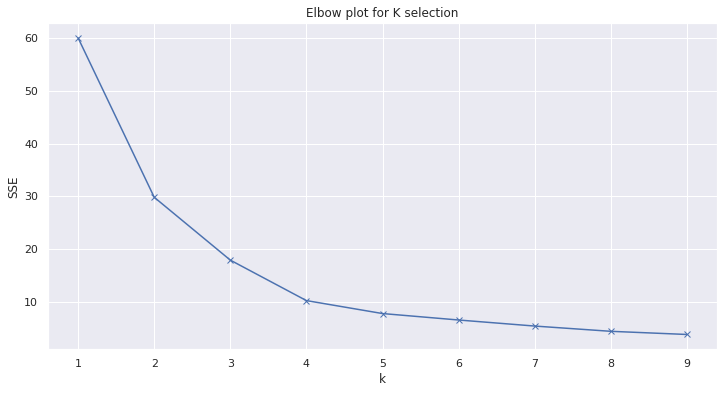

In [267]:
plt.figure(figsize = (12, 6))
plt.plot(K, sse, 'bx-')
plt.title('Elbow plot for K selection')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

The other approach, which resolves the difficulties in manually identifying the inflection point on the elbow plot, is to use a computational approach to finding the optimum k. One of the easiest you can use is the Kneedle algorithm, which is implemented in Python in a package called kneed.

In [268]:
from kneed import KneeLocator

In [269]:
kl = KneeLocator(range(1, 10), sse, curve = 'convex', direction = 'decreasing')

Using the Kneedle algorithm on our df_norm dataframe returns a value of 4, which is what we should use as our k value to get the optimum results.

In [270]:
kl.elbow

4

**Apply k-means clustering**

In [271]:
# Create k-mean object
kmeans = KMeans(n_clusters = 4, random_state = 42)

# Train model
kmeans.fit(df_norm)

# Predict class
df = df.assign(cluster = kmeans.labels_)

**Examining the customer segments**

To examine the clusters generated, we can use a groupby( ) on the newly created cluster column and then use the agg( ) function to calculate summary statistics for each cluster.

This gives us four clear clusters. The clusters created are fairly easy to distinguish, but this doesn’t mean that four represents the optimum number of clusters for practical marketing purposes.

In [272]:
df.groupby('cluster').agg(satisfaction = ('satisfaction', 'mean'), loyalty = ('loyalty', 'mean'), cluster_size = ('cluster', 'count'))

,satisfaction,loyalty,cluster_size
cluster,,,
0,3.428571,-1.382857,7
1,4.333333,0.820000,6
2,8.111111,-0.358889,9
3,8.625000,1.002500,8


Let's visualize the results by plotting the data colored by these labels.

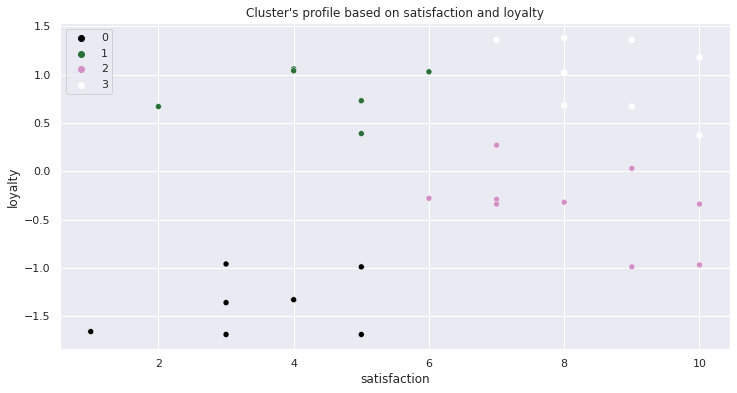

In [273]:
plt.figure(figsize = (12, 6))
sns.scatterplot(data = df, x = df['satisfaction'], y = df['loyalty'], hue = df['cluster'], palette = 'cubehelix')
plt.title("Cluster's profile based on satisfaction and loyalty")
plt.legend()
plt.show()

As illustrated in the above plot, we can get the following information for each of the segments:

**0.** customers with **low** satisfaction and **low** loyalty

**1.** customers with **average** satisfaction and **high** loyalty

**2.** customers with **high** satisfaction and **low** loyalty

**3.** customers with **high** satisfaction and **high** loyalty